# UnmuteAI Platform

The aim of the platform is to develop an environment that would be used to predict the sentiment of a perceived review using a content-based filtering algorithm. The resulting engine is a sentiment-based recommender engine combining both technologies together. The fields within Natural Language Processing and Machine learning (including Deep learning) scope are put to test for the development of this project. The dataset used are scraped contents from Metascritc website containing game reviews from critics and other game features. Adequate request has been made towards retrieving the content using both Request and BeautifulSoup API (Python libraries). The dataset contains 8671 rows and 8 columns. Some other columns are feature extracted using already present once. The Dataset has no missing values, the reason being that some checking procedures where implemented when web scraping the contents. Necessary Data cleaning using modules and utilities provided by the NLTK and TextBlob Libraries are performed on the the dataset. The normalisation with regards to removal of HTML tags have been done in the web scraping process. About 5 models are fitted on the cleaned and preporcessed dataset. All models outperformed the benchmarked accuracy score 

In [183]:
import json
dummy = pd.DataFrame({"name":[1,2,3]})
sub = {'item': json.loads(dummy.to_json())}

In [185]:
res = json.dumps(sub)
res = json.loads(res)
result = res['item']
#item1 = json.loads(result)
result

{'name': {'0': 1, '1': 2, '2': 3}}

In [ ]:
!pip install nltk


In [ ]:
nltk.download()

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import utils
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import contractions as ct
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import Word, TextBlob
import string
import re
import os

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tunde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading Game Review dataset from the system 

## Data Loading and Initial exploration 

In [127]:
print(os.getcwd())
game_reviews = os.getcwd() + "\data\game_reviews.csv"
print(game_reviews)

# Loading Data
df = pd.read_csv(game_reviews)

# Performing initial exploration
# Data shape
print(df.shape)

# No. of instances (rows) in the dataset...
print(len(df))

# Display the top 2 observations
print(df.head(2))

# Display the bottom 2 observations
print(df.tail(2))

# The column names are prefixed with whitespace, this need to be removed
df.columns = df.columns.str.strip()

# Normalizing the column names (change all to uppercase)
df.columns = df.columns.str.upper()

# showing the attributes in the dataset
print(df.columns)

# Checking for any missing values in the columns
print(df.isnull().sum())

# Learning more anout the dataset
print(df.describe())

# Estimating the mean metascore 
mean_score = df["METASCORE"].mean()
print("The mean score of metascore : {0:.2f}".format(mean_score))

# Unique games in the dataset
unique_games = np.unique(df["TITLE"])
print(len(unique_games))

# Unique platforms in the dataset
unique_platform = np.unique(df["PLATFORM"])
print("The list of platforms contained in the dataset: {}".format(len(unique_platform)))


C:\Users\tunde\Documents\Python\MLProjects\Data Prep\UnmuteAI
C:\Users\tunde\Documents\Python\MLProjects\Data Prep\UnmuteAI\data\game_reviews.csv
(8671, 8)
8671
                                 title     platform   release_date   \
0  The Legend of Zelda: Ocarina of Time  Nintendo 64    Nov-23-1998   
1              Tony Hawk's Pro Skater 2  PlayStation    Sep-20-2000   

                developer                                genres   \
0                 Nintendo            Action Adventure | Fantasy   
1  Neversoft Entertainment  Sports | Alternative | Skateboarding   

         reviewer    metascore   \
0      Gaming Maxx          100   
1  CNET Gamecenter          100   

                                              review  
0  Nothing but pure 100% fun challenging and leng...  
1  The best skateboarding game ever and one of th...  
                                         title   platform   release_date   \
8669  Skylar & Plux: Adventure on Clover Island         PC    May-19-201

## Data Preparation and Cleaning

- *Removing numeric values*
- *Removing punctuations*
- *performing contractions (dealing text inflections)*
- *Normalizing the text: includes transforming text into lowercase, removing tags if found, filter only alphanumeric features*
- *Transforming words into their base shape*
- *Removing stop words*

The following approach has been taken to categorize the metascore scheme definitions and categorization given by metacritic using their weighted average algorithm.

**<center>In the dataset, this is labled as pos: target - pos and UI: assigned a green color</center>**

| indications | metascore | label |
| :-: | :-: | :-: |
| Universal acclaim    | 90–100 | pos |
| Generally favorable reviews with some mixed positive oriented reviews    | 66–89 | pos |

       

**<center>In the dataset, this is labled as pos: target - neg and UI: assigned a red color</center>**

| indications | metascore | label
| :-: | :-: | :-: |
| Generally unfavorable reviews with some mixed negative oriented reviews   | 20–65 | neg |
| Overwhelming dislike    | 0–19 | neg |
           

In [124]:
#res = Word("").lemmatize()
#stemmer.stem("having")
#TextBlob("dirti").correct()
#stemmer.stem('resident')
res =TextBlob("precis").correct()
str(res)

'precise'

In [128]:
stemmer = PorterStemmer()
words = stopwords.words("english")
punctuations = string.punctuation

## Processing utilities

# removes inflection: I'll ->I will  He'd -> He had
def remove_contractions(text):
    return ct.fix(text)

# transform words into their base or root form: giving -> give, having -> have, discussion -> discuss, lengthy -> lengthi
def get_stemmed_text(word):
    #word = word.lower()
    #root = stemmer.stem(word)
    #return str(TextBlob(root).correct())
    return stemmer.stem(word)

# hide '-' from the list of puctuations available in the string.puctuation module
def reset_punct():
    holder = string.punctuation
    return re.sub("\''","",holder)

def get_cleaned_review(item):
    #punctuations = reset_punct()
    fixed_text = remove_contractions(item)
    processed_text = [i.lower() for i in re.split(r"\W+", fixed_text)]
    processed_text = [ i for i in processed_text if not i in punctuations]
    processed_text = [ i for i in processed_text if len(i) > 2 ] 
    processed_text = [ i for i in processed_text if i.isalpha()]
    processed_text = [ get_stemmed_text(i) for i in processed_text if not i in words]
    return processed_text

# Deprecated
def metascore_to_label_depr(metascore):
    if metascore > 74:
        return 2
    elif metascore > 49 and metascore < 75:
        return 1
    else:
        return 0

# Label encoding 
def metascore_to_label(metascore):
    if metascore > 65:
        return 1
    else:
        return 0

# Split release date by the delimiter '-': from creating a new column 'RELEASE_YEAR'    
def get_release_year(release_year):
    return release_year.split("-")[2]



In [129]:
# Feature engineering: creating a new column off the REVIEW column 

df['PROCESSED_REVIEW'] = df['REVIEW'].apply(lambda row: " ".join(get_cleaned_review(row)))

df['RELEASE_YEAR'] = df['RELEASE_DATE'].apply(get_release_year)

df['TOKENIZED_REVIEW'] = df['PROCESSED_REVIEW'].apply(lambda row: [token for token in word_tokenize(row)])

df["LABEL"] = df.METASCORE.apply(lambda metascore: metascore_to_label(metascore))

df['REVIEW_WORD_COUNT'] = df['TOKENIZED_REVIEW'].apply(len)

df['SENTIMENT'] = df['PROCESSED_REVIEW'].apply(lambda review: TextBlob(review).sentiment.polarity)

df['SUBJECTIVITY'] = df['PROCESSED_REVIEW'].apply(lambda review: TextBlob(review).sentiment.subjectivity)


In [133]:
# Processed dataset
df.columns


Index(['TITLE', 'PLATFORM', 'RELEASE_DATE', 'DEVELOPER', 'GENRES', 'REVIEWER',
       'METASCORE', 'REVIEW', 'PROCESSED_REVIEW', 'RELEASE_YEAR',
       'TOKENIZED_REVIEW', 'LABEL', 'REVIEW_WORD_COUNT', 'SENTIMENT',
       'SUBJECTIVITY'],
      dtype='object')

In [132]:
df[:10]

,TITLE,PLATFORM,RELEASE_DATE,DEVELOPER,GENRES,REVIEWER,METASCORE,REVIEW,PROCESSED_REVIEW,RELEASE_YEAR,TOKENIZED_REVIEW,LABEL,REVIEW_WORD_COUNT,SENTIMENT,SUBJECTIVITY
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,Nov-23-1998,Nintendo,Action Adventure | Fantasy,Gaming Maxx,100,Nothing but pure 100% fun challenging and leng...,noth pure fun challeng lengthi,1998,"[noth, pure, fun, challeng, lengthi]",1,5,0.257143,0.350000
1,Tony Hawk's Pro Skater 2,PlayStation,Sep-20-2000,Neversoft Entertainment,Sports | Alternative | Skateboarding,CNET Gamecenter,100,The best skateboarding game ever and one of th...,best skateboard game ever one greatest playsta...,2000,"[best, skateboard, game, ever, one, greatest, ...",1,9,0.300000,0.525000
2,Grand Theft Auto IV,PlayStation 3,Apr-29-2008,Rockstar North,Action Adventure | Modern | Modern | Open-World,Jolt Online Gaming UK,100,Grand Theft Auto IV is not a perfect game but ...,grand theft auto perfect game fantast start fi...,2008,"[grand, theft, auto, perfect, game, fantast, s...",1,24,0.157143,0.600000
3,SoulCalibur,Dreamcast,Sep-8-1999,Namco,Action | Fighting | 3D,CheckOut,100,I guarantee you'll be amazed at how phenomenal...,guarante amaz phenomen game look abl put,1999,"[guarante, amaz, phenomen, game, look, abl, put]",1,7,-0.400000,0.400000
4,Grand Theft Auto IV,Xbox 360,Apr-29-2008,Rockstar North,Action Adventure | Modern | Modern | Open-World,Official Xbox Magazine UK,100,It's got a world you believe in a cast you car...,got world believ cast care script stuf brillia...,2008,"[got, world, believ, cast, care, script, stuf,...",1,14,0.900000,1.000000
5,Super Mario Galaxy,Wii,Nov-12-2007,Nintendo,Action | Platformer | Platformer | 3D | 3D,NTSC-uk,100,Mario has not grown older but younger with tim...,mario grown older younger time slender suppl g...,2007,"[mario, grown, older, younger, time, slender, ...",1,42,0.211111,0.406173
6,Super Mario Galaxy 2,Wii,May-23-2010,Nintendo EAD Tokyo,Action | Platformer | Platformer | 3D | 3D,Gamereactor Sweden,100,Improves on the first game and charms every bo...,improv first game charm everi bone game love b...,2010,"[improv, first, game, charm, everi, bone, game...",1,18,0.081250,0.429167
7,Red Dead Redemption 2,Xbox One,Oct-26-2018,Rockstar Games,Action Adventure | Open-World,GamingTrend,100,Red Dead Redemption 2 raises the bar for sandb...,red dead redempt rais bar sandbox adventur gam...,2018,"[red, dead, redempt, rais, bar, sandbox, adven...",1,27,-0.150000,0.300000
8,Grand Theft Auto V,Xbox One,Nov-18-2014,Rockstar North,Action Adventure | Modern | Open-World,X-ONE Magazine UK,100,It’s just a great game tying to be even better...,great game tie even better case work case ulti...,2014,"[great, game, tie, even, better, case, work, c...",1,23,0.366667,0.541667
9,Grand Theft Auto V,PlayStation 3,Sep-17-2013,Rockstar North,Modern | Action Adventure | Modern | Open-World,LEVEL (Czech Republic),100,GTA V fulfills the idea of a gaming sandbox wh...,gta fulfil idea game sandbox entertain mani di...,2013,"[gta, fulfil, idea, game, sandbox, entertain, ...",1,18,-0.400000,0.400000


In [138]:
## saving the processed dataframe as a binary file using pickle
# The content could be retrieved later from backup using pd.read_pickle(binary)
#df.to_pickle("processed_data.pickle")
df.to_csv(".\data\processed_data.csv")

## Exploratory Data Analysis (EDA)

[Text(0.5, 0, 'most common words'),
 Text(0, 0.5, '# occurences'),
 Text(0.5, 1.0, 'Plot of the most common words...')]

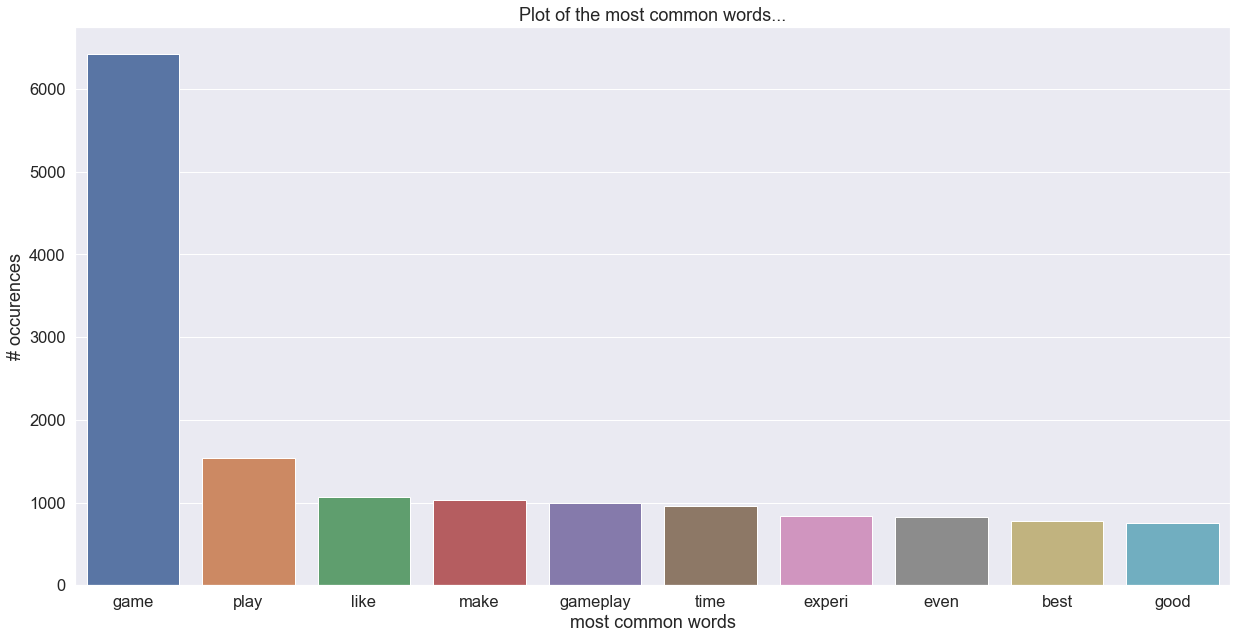

In [235]:
from nltk import FreqDist
import seaborn as sns
sns.set(font_scale=1.5)

freq_dist_pos = FreqDist(X for i in df.TOKENIZED_REVIEW for X in i if len(X) > 3) 
most_common = freq_dist_pos.most_common(10)
most_common_df_ = pd.DataFrame(most_common, columns = ["WORD","COUNT"])
plot = sns.barplot(x='WORD',y="COUNT", data=most_common_df_)
plot.set(xlabel="most common words", ylabel = "# occurences", title = "Plot of the most common words...")

In [236]:
# Most common words
most_common_df_

,WORD,COUNT
0,game,6428
1,play,1539
2,like,1072
3,make,1030
4,gameplay,995
5,time,959
6,experi,842
7,even,821
8,best,773
9,good,748


<AxesSubplot:>

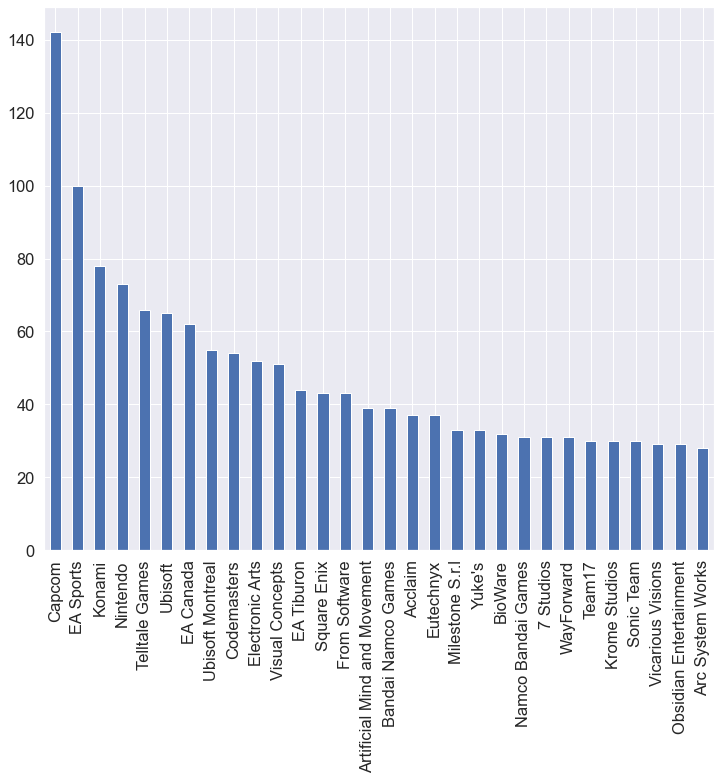

In [237]:
df['DEVELOPER'].value_counts().head(30).plot(kind='bar', figsize=(12,10))

<AxesSubplot:xlabel='PLATFORM', ylabel='count'>

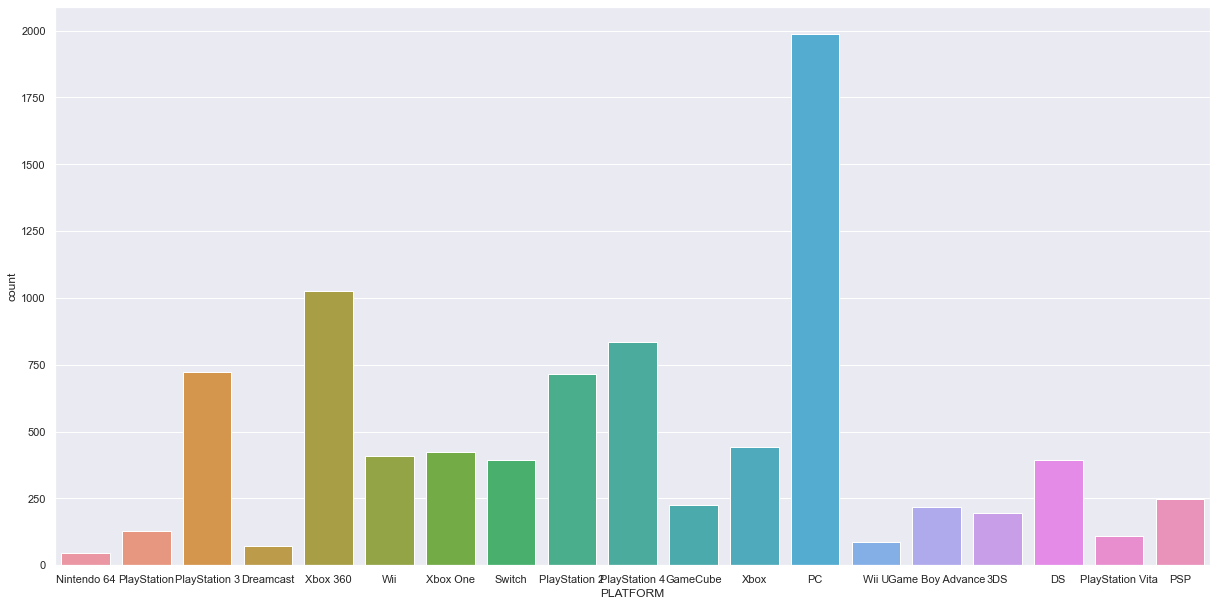

In [238]:
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(20.7,10.27)})
sns.countplot(x='PLATFORM', data=df)

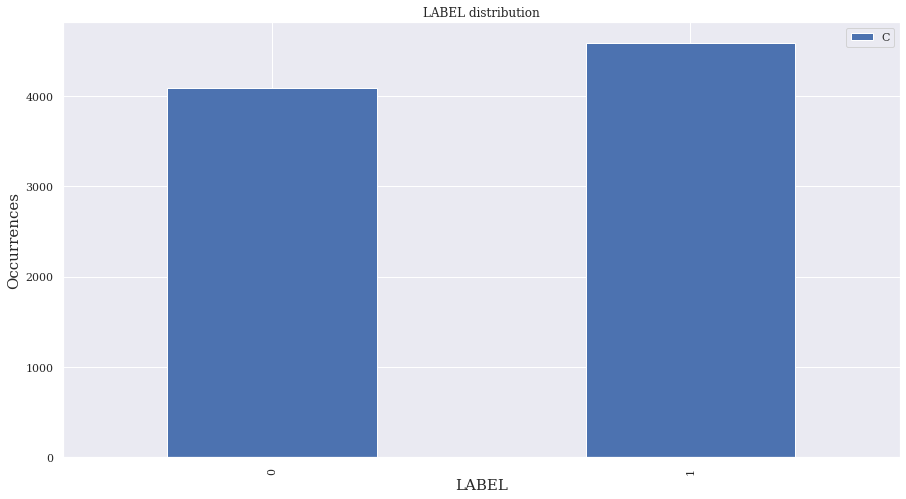

In [239]:
#df.filter(["REVIEW", "METASCORE", "RELEASE_YEAR"])
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
df.groupby('LABEL').REVIEW.count().plot.bar(figsize=(15, 8))
plt.title("LABEL distribution")
plt.ylabel('Occurrences', fontsize=15)
plt.xlabel('LABEL', fontsize=15)
plt.legend("CLASS")
plt.show()

In [244]:
df.groupby("LABEL").describe()

METASCORE                                                        \
          count       mean        std   min   25%   50%    75%    max   
LABEL                                                                   
0        4088.0  44.602495  11.949050   0.0  35.0  42.0   55.0   65.0   
1        4583.0  91.838316   8.215549  66.0  85.0  92.0  100.0  100.0   

      REVIEW_WORD_COUNT             ... SENTIMENT      SUBJECTIVITY            \
                  count       mean  ...       75%  max        count      mean   
LABEL                               ...                                         
0                4088.0  18.534491  ...  0.100000  1.0       4088.0  0.400291   
1                4583.0  20.878027  ...  0.237083  1.0       4583.0  0.418476   

                                                         
            std  min       25%       50%       75%  max  
LABEL                                                    
0      0.203010  0.0  0.300000  0.400000  0.511111  1.0  
1      0.191885  0.0  0.327273  0.414286  0.525000  1.0  

[2 rows x 32 columns]

## Baseline | Benchmark Accuracy

In [134]:
## displaying the number of observations with negative sentiment in the dataset.
print("Negative Label: {}".format((df["LABEL"] == 0).sum()))

## displaying the number of observations with positive sentiment in the dataset.
print("Positive Label: {}".format((df["LABEL"] == 1).sum()))

## The baseline accuracy
## this the ratio of the majority class (pos label) to the size of the dataset.
## This would be used as a benchmark when evaluating the minimum accuracy for the models
print("Benchmark Accuracy: {:.2f}".format((df["LABEL"] == 1).sum()/len(df)))

Negative Label: 4088
Positive Label: 4583
Benchmark Accuracy: 0.53


## Training and Testing Set

In [135]:
df = utils.shuffle(df)
# isolating the target column (label)
y = df['LABEL']

X = df.drop(['LABEL'], axis=1)

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Displaying the shape of the features and target section of the dataset
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6936, 14)
(1735, 14)
(6936,)
(1735,)


In [136]:
# proportion 0 and 1 in both train and test set
print((y_test == 0).sum())
print((y_test == 1).sum())
print('\n')
print((y_train == 0).sum())
print((y_train == 1).sum())

824
911


3264
3672


## Developing models and Fitting them on the Extracted features

### 1. Fitting the Naive Bayes model on the training set and perform performance evaluation on it 

In [139]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer

nb_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('nb', MultinomialNB())])
parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [1, 1e-1, 1e-2]
}

#cls_naivebayes_ = MultinomialNB()
clf = GridSearchCV(nb_clf, param_grid=parameters_, cv=5)
clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)

print(clf.best_params_);print('\n')
y_pred = clf.predict(X_test["PROCESSED_REVIEW"].values)

print(classification_report(y_test, y_pred, digits=3));print('\n')
print('Accuracy Score: {}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score: {}\n'.format(confusion_matrix(y_test, y_pred, labels=[1,0])))


print(y_pred[300:310])
print(y_test[300:310].values)

{'nb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


              precision    recall  f1-score   support

           0      0.876     0.765     0.817       824
           1      0.809     0.902     0.853       911

    accuracy                          0.837      1735
   macro avg      0.843     0.833     0.835      1735
weighted avg      0.841     0.837     0.836      1735



Accuracy Score: 0.8368876080691643


Confusion matrix Score: [[822  89]
 [194 630]]
[0 1 1 1 0 0 1 1 1 1]
[0 1 0 0 0 0 1 1 0 0]


In [151]:
## Testing how good the model is...
X_pred = clf.predict(["best games"])
## Prediction
print(X_pred)

X_pred = clf.predict(["It is a lovely game but I had a really bad experience while playing it..."])
## Prediction
print(X_pred)

X_pred = clf.predict_proba(["best games"])
## Prediction
print(X_pred)

X_pred = clf.predict_proba(["It is a lovely game but I had a really bad experience while playing it..."])
## Prediction
print(X_pred)

[1]
[0]
[[0.15 0.85]]
[[1. 0.]]


### 2. Fitting RandomForestClassifier on the train set

In [143]:
from sklearn.ensemble import RandomForestClassifier

#rf_classifier_ = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 100)
 #'clf__n_estimators': [20],
#'clf__max_features': ['auto', 'sqrt', 'log2'],
#'clf__max_depth' : [4,5,6,7,8]

rf_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators = 20,random_state = 200))])
parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__criterion' :['gini', 'entropy']
}


clf = GridSearchCV(rf_clf, param_grid=parameters_, cv=5)
clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)

print(clf.best_params_);print('\n')

y_pred = clf.predict(X_test["PROCESSED_REVIEW"].values)

print(classification_report(y_test, y_pred, digits=3))
print('Accuracy Score: {}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score: {}\n'.format(confusion_matrix(y_test, y_pred, labels=[1,0])))

print(y_pred[300:310])
print(y_test[300:310].values)

{'clf__criterion': 'entropy', 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


              precision    recall  f1-score   support

           0      0.768     0.783     0.775       824
           1      0.800     0.786     0.793       911

    accuracy                          0.784      1735
   macro avg      0.784     0.784     0.784      1735
weighted avg      0.785     0.784     0.785      1735

Accuracy Score: 0.7844380403458213


Confusion matrix Score
: [[716 195]
 [179 645]]
[0 1 1 1 0 0 0 1 0 1]
[0 1 0 0 0 0 1 1 0 0]


### 3. Fitting SVM method (SVC) on the train set 

In [ ]:
from sklearn import svm

parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__kernel': ['linear','rbf']
}

svc_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('svc', svm.SVC())])

svm_clf = GridSearchCV(svc_clf, param_grid=parameters_, cv=5)
svm_clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)
print(svm_clf.best_params_);print('\n')

y_pred = svm_clf.predict(X_test["PROCESSED_REVIEW"].values)

print(classification_report(y_test, y_pred, digits=3));print('\n')
print('Accuracy Score: {}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score:\n {}'.format(confusion_matrix(y_test, y_pred)))

print(y_pred[300:310])
print(y_test[300:310].values)

### 4. Logistic regression

In [274]:
from sklearn.linear_model import LogisticRegression


parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'lr__C': [0.1, 1, 10, 100, 1000]
}

lr_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lr',  LogisticRegression())])

LR_clf = GridSearchCV(lr_clf, param_grid=parameters_, cv=5)
LR_clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)

print(LR_clf.best_params_);print('\n')
# Predict with the unseen set (testing set)
y_pred = LR_clf.predict(X_test["PROCESSED_REVIEW"].values)

print(classification_report(y_test, y_pred, digits=3));print('\n')
print('Accuracy Score: {}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score:\n {}'.format(confusion_matrix(y_test, y_pred)))

print(y_pred[300:310])
print(y_test[300:310].values)

              precision    recall  f1-score   support

           0      0.848     0.788     0.817       810
           1      0.825     0.877     0.850       925

    accuracy                          0.835      1735
   macro avg      0.837     0.832     0.834      1735
weighted avg      0.836     0.835     0.835      1735



Accuracy Score: 0.8351585014409222


Confusion matrix Score:
 [[638 172]
 [114 811]]
[1 0 1 1 0 1 1 0 0 1]
[1 0 1 0 0 1 0 0 0 1]


In [297]:
## Testing how good the model is...
X_pred = LR_clf.predict(["It is a lovely game"])
## Prediction
print(X_pred)

X_pred = LR_clf.predict(["I had a blissful experience with the game"])
## Prediction
print(X_pred)

[1]
[1]


### 5. Basic Neural Network Using Keras: Training word Embedding and fit NN on the word vector (word embedding)

In [36]:
!pip install keras
!pip install theano
!pip install tensorflow

  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=40826e379d5132a9031a400a8bbc223eb65da8f0e25649a3c1a07fac4d6977e7
  Stored in directory: c:\users\tunde\appdata\local\pip\cache\wheels\26\68\6f\745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built theano
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached absl-py-0.9.0.tar.gz (104 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=09c37793c6ba84e83bec504ace7aeb34bed7bf9c82065fb256565f226af35704
  Stored in directory: c:\users\tunde\appdata\local\pip\cache\whe

In [187]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [188]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
#encoder = LabelEncoder()
#encoded_dec = encoder.fit_transform(y) 
#one_hot_Y = to_categorical(encoded_dec)

y = df['LABEL'].values
# Encoding reviews with integer
sequence_hash_size = 200
encoded_features = [one_hot(review, sequence_hash_size) for review in df.PROCESSED_REVIEW.values]
#print(encoded_features)
# using 40 words as the max length (Indicating words with relatively close in meaning) for dense word vector
max_length = 40
padded_reviews = pad_sequences(encoded_features, maxlen=max_length, padding='post')

# instantiate the model

model = Sequential()
model.add(Dense(200, activation='relu',input_shape=(max_length,)))
model.add(Dense(200, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(padded_reviews, y,epochs=20, batch_size=1, verbose=1)
print(model.summary())
loss, accuracy = model.evaluate(padded_reviews, y, verbose=0)
print('Accuracy: {:.2f}'.format(accuracy))


Epoch 1/20
8671/8671 [==============================] - 17s 2ms/step - loss: 0.6919 - accuracy: 0.5277
Epoch 2/20
8671/8671 [==============================] - 19s 2ms/step - loss: 0.6927 - accuracy: 0.5206
Epoch 3/20
8671/8671 [==============================] - 21s 2ms/step - loss: 0.6920 - accuracy: 0.5285
Epoch 4/20
8671/8671 [==============================] - 22s 3ms/step - loss: 0.6926 - accuracy: 0.5207
Epoch 5/20
8671/8671 [==============================] - 22s 3ms/step - loss: 0.6917 - accuracy: 0.5285
Epoch 6/20
8671/8671 [==============================] - 23s 3ms/step - loss: 0.6922 - accuracy: 0.5223
Epoch 7/20
8671/8671 [==============================] - 17s 2ms/step - loss: 0.6922 - accuracy: 0.5239
Epoch 8/20
8671/8671 [==============================] - 21s 2ms/step - loss: 0.6919 - accuracy: 0.5285
Epoch 9/20
8671/8671 [==============================] - 23s 3ms/step - loss: 0.6920 - accuracy: 0.5285
Epoch 10/20
8671/8671 [==============================] - 25s 3ms/step - l

## Sentiment-Based Recommender Engine

In [162]:
#vectorizer_model = TfidfVectorizer(max_df=0.9)
#vectorizer_model.fit(X_train["PROCESSED_TEXT"].values)
#  displary vocabulary dictionary
#print(vectorizer_model.vocabulary_)
#print(vectorizer_model.idf_)

vectorizer_model = CountVectorizer()

# encode training set
vect_data = vectorizer_model.fit_transform(df["PROCESSED_REVIEW"].values)
print(list(vectorizer_model.vocabulary_)[:20])

#vect_test_data = vectorizer_model.transform(X_test["PROCESSED_REVIEW"].values)

# encoded vector
print(vect_data.shape)
print(vect_data.toarray())

#print(vect_test_data.shape)
#print(vect_test_data.toarray())

# first 50 features
print(vectorizer_model.get_feature_names()[:50])

['career', 'mode', 'insultingli', 'linear', 'short', 'live', 'progress', 'interspers', 'cheesi', 'action', 'video', 'peopl', 'give', 'mad', 'prop', 'kook', 'way', 'addit', 'take', 'account']
(8671, 10165)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['aaa', 'aback', 'abandon', 'abba', 'abbey', 'abbrevi', 'abc', 'abe', 'abhorr', 'abid', 'abil', 'abl', 'ablaz', 'aboard', 'abomin', 'abound', 'abras', 'abridg', 'abrupt', 'abruptli', 'absenc', 'absent', 'absolut', 'absolv', 'absorb', 'abstract', 'absurd', 'absurdist', 'absurdli', 'abund', 'abus', 'abysm', 'abyss', 'academi', 'academia', 'acc', 'accel', 'acceler', 'accent', 'accentu', 'accept', 'access', 'accessori', 'accid', 'accident', 'acclaim', 'acclim', 'accolad', 'accommod', 'accompani']


In [168]:
if type(similarity) == np.ndarray:
    print("here...")

here...


In [163]:
from sklearn.metrics.pairwise import cosine_similarity
import pickle
similarity = cosine_similarity(vect_data,vect_data)
print(similarity[1000:1020])

sim_scores =[]

def sortHelper(item):
    return item[3]

def Sorter(desc,obj):
     obj.sort(reverse=desc,key=sortHelper)

def get_recommended_games(title="",sim=similarity, rec_games=[], review_prob=1):
    #game_title = "*****" "Tony Hawk's Pro Skater 2"
    if title:
        sim_scores = df.loc[df["TITLE"] == title, ["TITLE"]]
        if len(sim_scores['TITLE'].values):
            
            sim_scores = sim_scores.index[0]
            sim_score = pd.Series(similarity[sim_scores])
            print(list(sim_score.sort_values(ascending= False))[:10])
            rec_games_index = sim_score.sort_values(ascending= False).index[:10]
            rec_games = [df.loc[df.index == game, ["TITLE","PLATFORM","RELEASE_DATE","SENTIMENT"]].values.flatten() for game in rec_games_index]
            Sorter(True,rec_games)
            with open('game_recommendation.data', 'wb') as fd:
                ## Storing binary stream using the file handler...
                pickle.dump(rec_games, fd)
            return rec_games_index,rec_games
        else:
            return "Game not found..."
    elif review_prob >= 0:
        sim_scores = df.loc[df["SENTIMENT"] >= (review_prob-0.5), ["SENTIMENT"]]
        if len(sim_scores['SENTIMENT'].values):
            sim_scores = sim_scores.index[0]
            sim_score = pd.Series(similarity[sim_scores])
            print(list(sim_score.sort_values(ascending= False))[:10])
            rec_games_index = sim_score.sort_values(ascending= False).index[:10]
            rec_games = [df.loc[df.index == game, ["TITLE","PLATFORM","RELEASE_DATE","SENTIMENT"]].values.flatten() for game in rec_games_index]
            Sorter(True,rec_games)
            with open('game_recommendation.data', 'wb') as fd:
                ## Storing binary stream using the file handler...
                pickle.dump(rec_games, fd)
            return rec_games_index,rec_games
        else:
            return "Games not found..."
    else:
        print("Game title not provided...")
get_recommended_games("The Guest",review_prob=0)

[[0.         0.         0.         ... 0.06900656 0.23570226 0.08512565]
 [0.         0.         0.         ... 0.048795   0.16666667 0.        ]
 [0.06201737 0.0438529  0.         ... 0.06629935 0.1132277  0.08178608]
 ...
 [0.04082483 0.         0.         ... 0.04364358 0.1490712  0.        ]
 [0.         0.05773503 0.         ... 0.04364358 0.1490712  0.        ]
 [0.         0.         0.         ... 0.05096472 0.17407766 0.        ]]
[0.9999999999999998, 0.3944053188733077, 0.3892494720807615, 0.38729833462074165, 0.36514837167011066, 0.3478327964999673, 0.3478327964999673, 0.34641016151377546, 0.3464101615137754, 0.3464101615137754]


(Int64Index([8667, 2747, 4134, 6161, 2187, 3585, 6184, 7776, 3865, 5335], dtype='int64'),
 [array(['Frozen Synapse Prime', 'PlayStation Vita', 'Sep-23-2014', 0.8],
        dtype=object),
  array(['Fight Night Round 3', 'PlayStation 2', 'Feb-20-2006',
         0.2333333333333333], dtype=object),
  array(['Star Wars The Clone Wars: Republic Heroes', 'PlayStation 3',
         'Oct-6-2009', 0.15999999999999998], dtype=object),
  array(['Dead or Alive Xtreme 3: Fortune', 'PlayStation 4', 'Mar-24-2016',
         0.10357142857142856], dtype=object),
  array(['WWF No Mercy', 'Nintendo 64', 'Nov-17-2000', 0.0], dtype=object),
  array(['Need for Speed Undercover', 'Xbox 360', 'Nov-17-2008',
         -0.019999999999999997], dtype=object),
  array(['Touhou Kobuto V: Burst Battle', 'PlayStation 4', 'Oct-10-2017',
         -0.08194444444444449], dtype=object),
  array(['Cat Girl Without Salad: Amuse-Bouche', 'Switch', 'Apr-1-2020',
         -0.1326923076923077], dtype=object),
  array(['Call of Cthu

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
vec.fit(X_train)
x_train=vec.transform(X_train)
x_test=vec.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(16, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])